In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair
import sklearn
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold

In [2]:
df = pd.read_csv('/kaggle/input/task-work/dataset.csv')

train_df = pd.read_csv('/kaggle/input/task-work/train_data.csv')

test_df = pd.read_csv('/kaggle/input/task-work/test_data.csv')

In [3]:
df.describe()

,Temperature,Moisture,Watering
count,153.000000,153.000000,153.000000
mean,32.647059,63.764706,165.215686
std,4.321718,12.764447,20.721506
min,25.000000,40.000000,130.000000
25%,29.000000,54.000000,148.000000
50%,33.000000,65.000000,166.000000
75%,36.000000,73.000000,183.000000
max,40.000000,85.000000,200.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         153 non-null    object
 1   Temperature  153 non-null    int64 
 2   Moisture     153 non-null    int64 
 3   Watering     153 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 4.9+ KB


In [5]:
df.head(10)

,Date,Temperature,Moisture,Watering
0,2023-04-01,38,55,147
1,2023-04-02,36,44,183
2,2023-04-03,39,61,146
3,2023-04-04,32,47,143
4,2023-04-05,32,66,139
5,2023-04-06,36,72,184
6,2023-04-07,35,51,154
7,2023-04-08,33,60,153
8,2023-04-09,32,43,167
9,2023-04-10,29,58,165


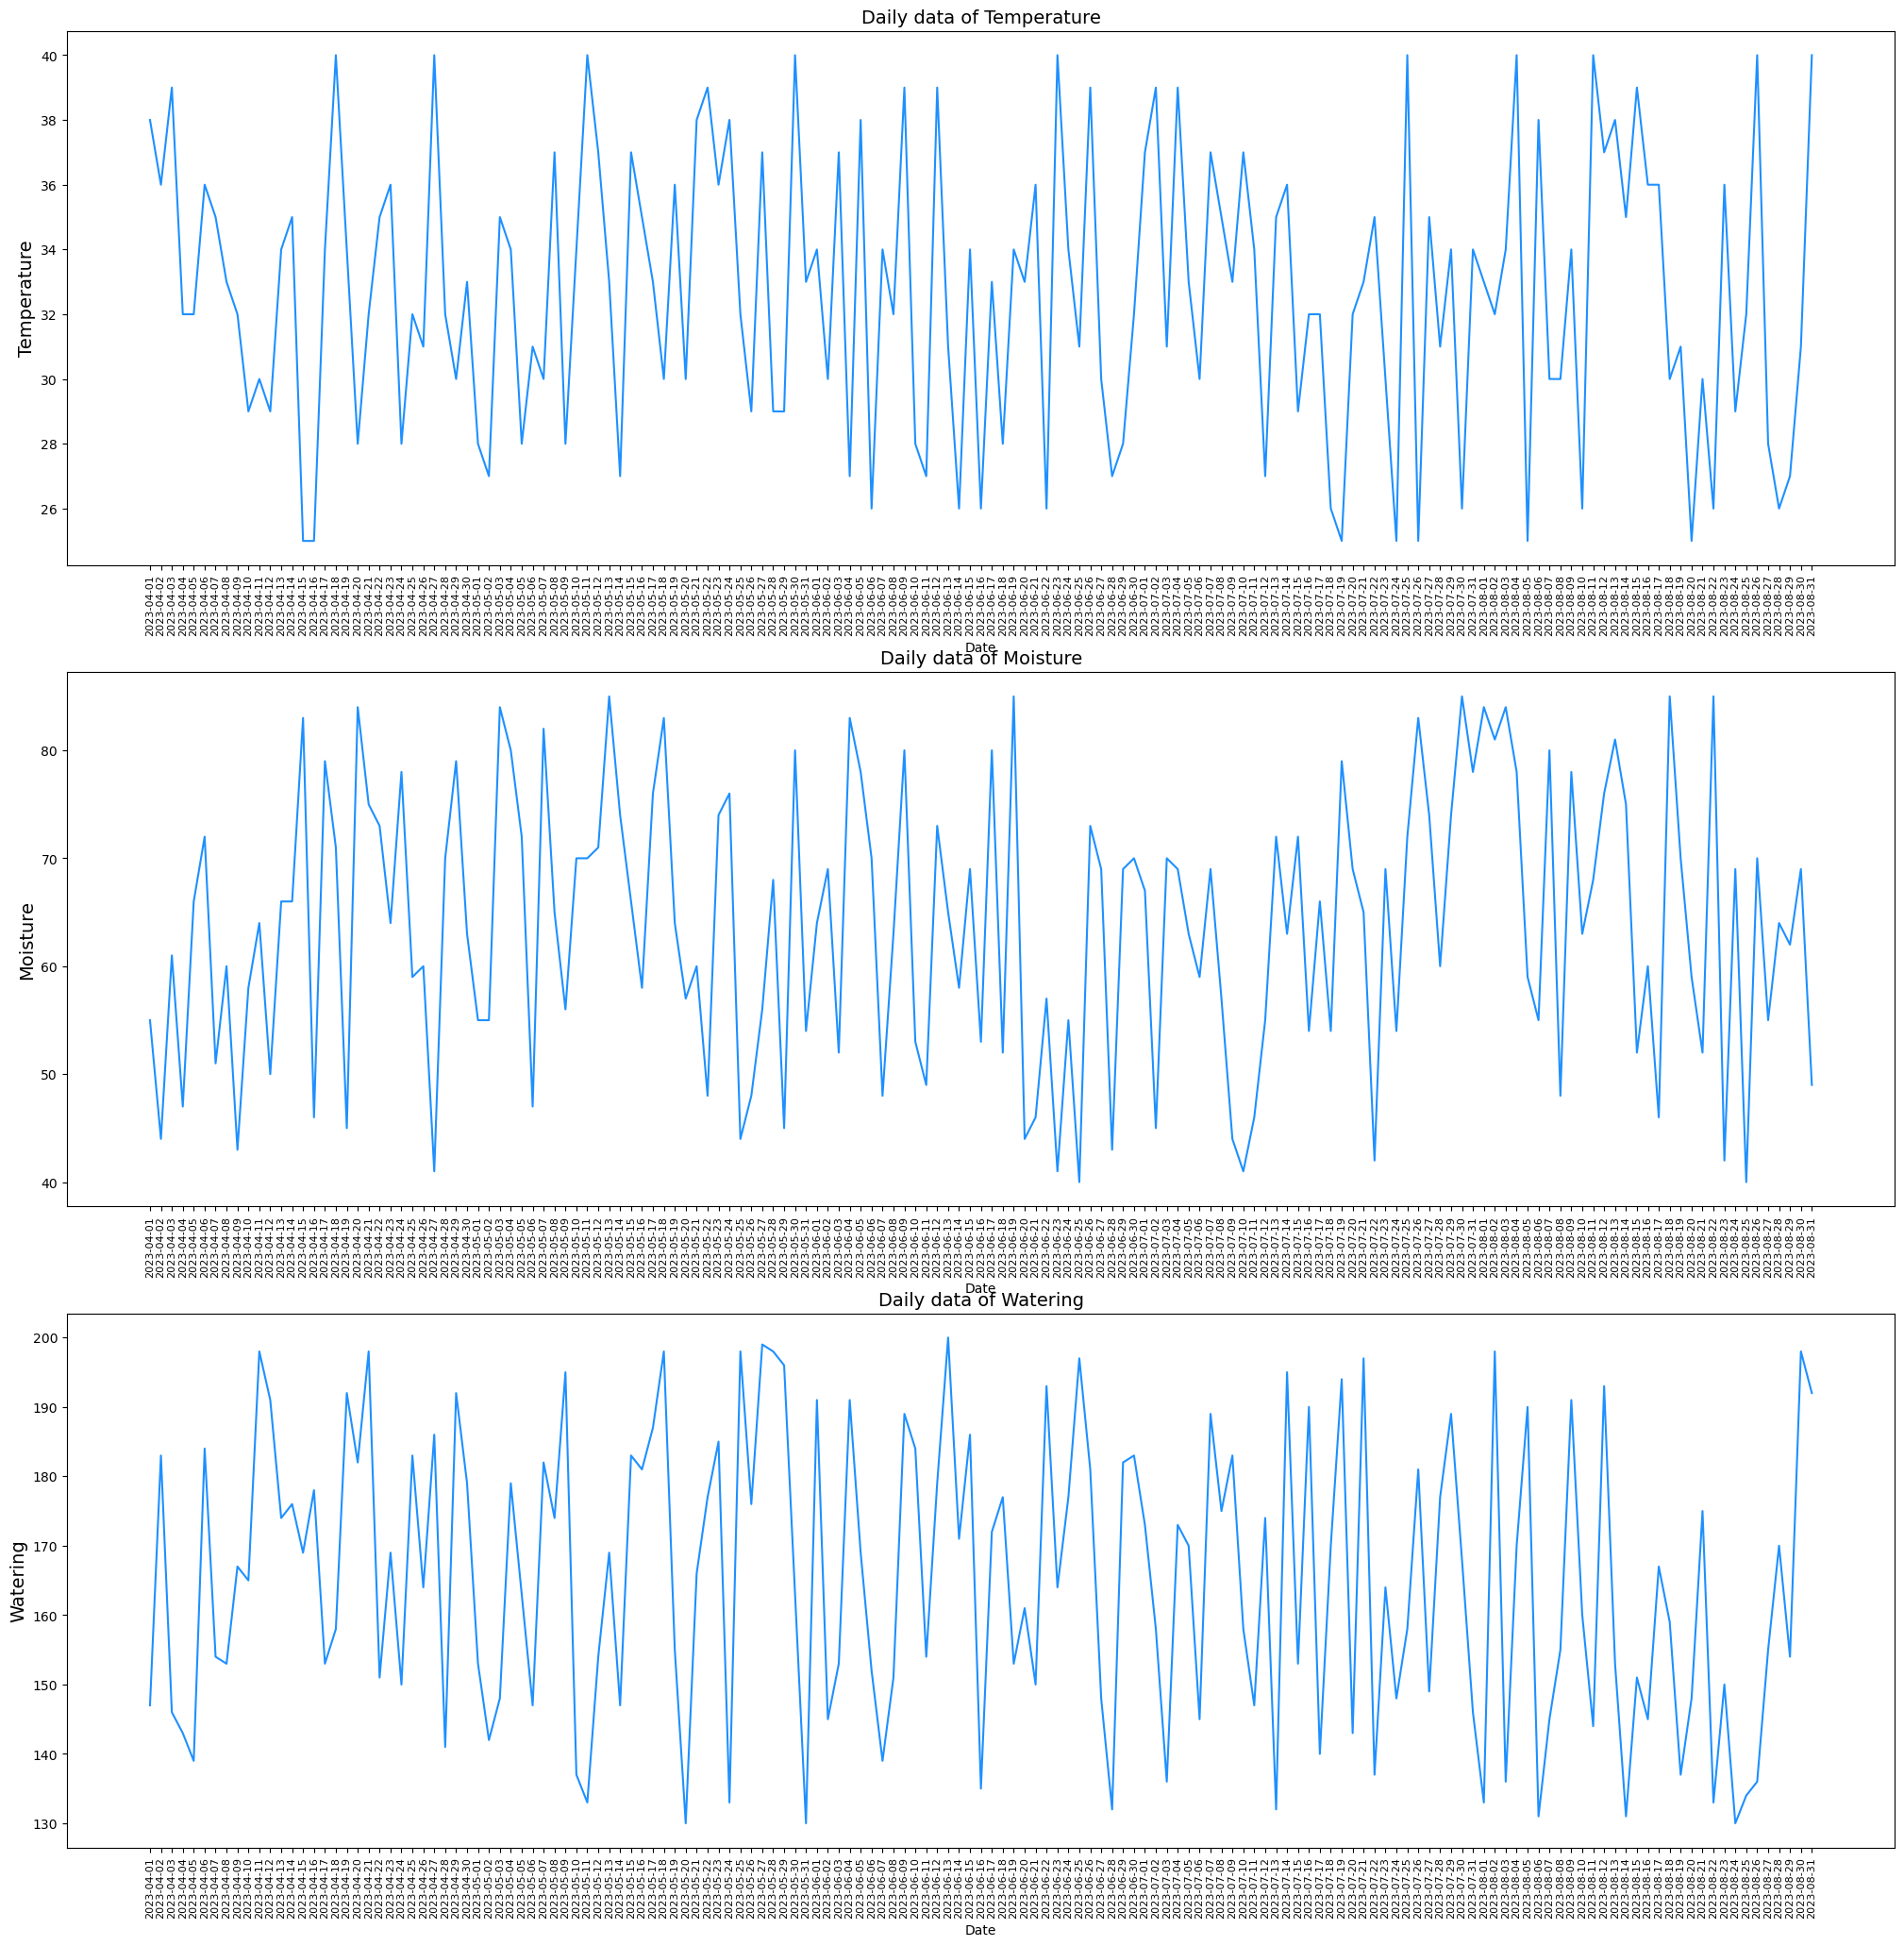

In [6]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(25, 25))

for i, column in enumerate(df.drop('Date', axis=1).columns):
    plot = sns.lineplot(x=df['Date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    plot.xaxis.set_major_locator(ticker.FixedLocator(plot.get_xticks()))
    ax[i].tick_params(axis='x', labelrotation=90, labelsize=8)
    ax[i].set_title('Daily data of {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    

    



In [7]:
df.columns

Index(['Date', 'Temperature', 'Moisture', 'Watering'], dtype='object')

<AxesSubplot:>

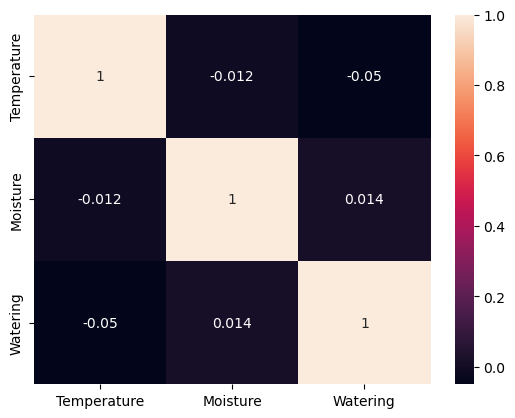

In [83]:
sns.heatmap(df.corr(), annot=True, )

In [8]:
def date_features(df, label):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    df['date'] = df.Date
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime('%A')
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    y=df[label]
    return X, y


In [9]:
X, y = date_features(df, label='Moisture')
df_moist = pd.concat([X, y], axis=1)
df_moist

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Moisture
0,Saturday,2,April,2023,91,1,13,55
1,Sunday,2,April,2023,92,2,13,44
2,Monday,2,April,2023,93,3,14,61
3,Tuesday,2,April,2023,94,4,14,47
4,Wednesday,2,April,2023,95,5,14,66
...,...,...,...,...,...,...,...,...
148,Sunday,3,August,2023,239,27,34,55
149,Monday,3,August,2023,240,28,35,64
150,Tuesday,3,August,2023,241,29,35,62
151,Wednesday,3,August,2023,242,30,35,69


In [10]:
X, y = date_features(df, label='Temperature')
df_temp = pd.concat([X, y], axis=1)
df_temp

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Temperature
0,Saturday,2,April,2023,91,1,13,38
1,Sunday,2,April,2023,92,2,13,36
2,Monday,2,April,2023,93,3,14,39
3,Tuesday,2,April,2023,94,4,14,32
4,Wednesday,2,April,2023,95,5,14,32
...,...,...,...,...,...,...,...,...
148,Sunday,3,August,2023,239,27,34,28
149,Monday,3,August,2023,240,28,35,26
150,Tuesday,3,August,2023,241,29,35,27
151,Wednesday,3,August,2023,242,30,35,31


In [11]:
X, y = date_features(df, label='Watering')
df_water = pd.concat([X, y], axis=1)
df_water

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Watering
0,Saturday,2,April,2023,91,1,13,147
1,Sunday,2,April,2023,92,2,13,183
2,Monday,2,April,2023,93,3,14,146
3,Tuesday,2,April,2023,94,4,14,143
4,Wednesday,2,April,2023,95,5,14,139
...,...,...,...,...,...,...,...,...
148,Sunday,3,August,2023,239,27,34,155
149,Monday,3,August,2023,240,28,35,170
150,Tuesday,3,August,2023,241,29,35,154
151,Wednesday,3,August,2023,242,30,35,198


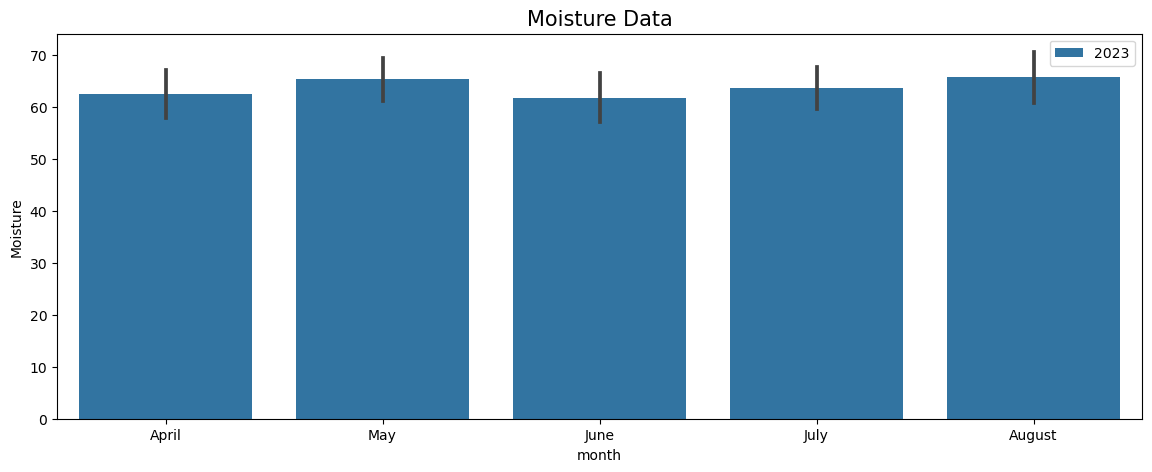

In [12]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Moisture",hue = 'year',data=df_moist)
a.set_title("Moisture Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

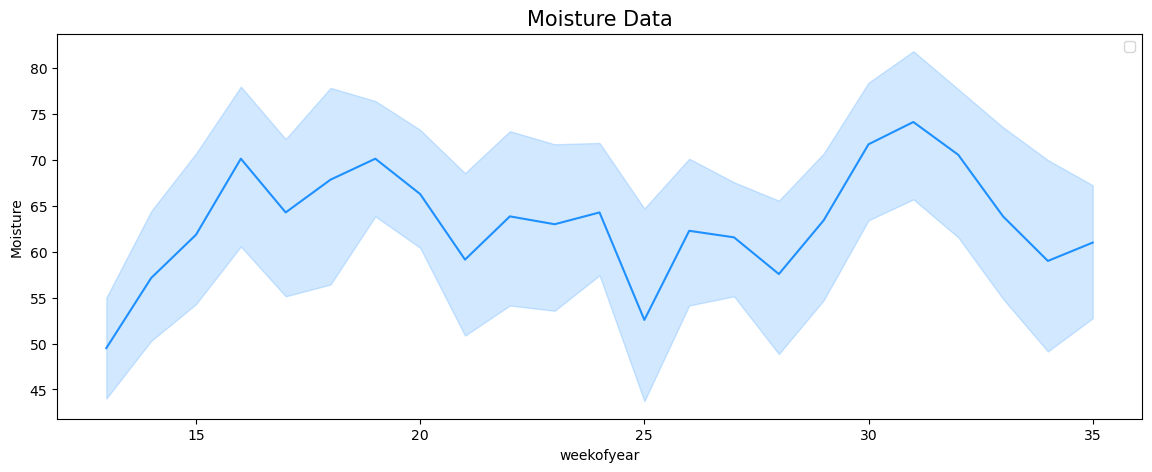

In [13]:

fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.lineplot(x=df_moist['weekofyear'], y=df_moist['Moisture'].fillna(method='ffill'), color='dodgerblue')
a.set_title("Moisture Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

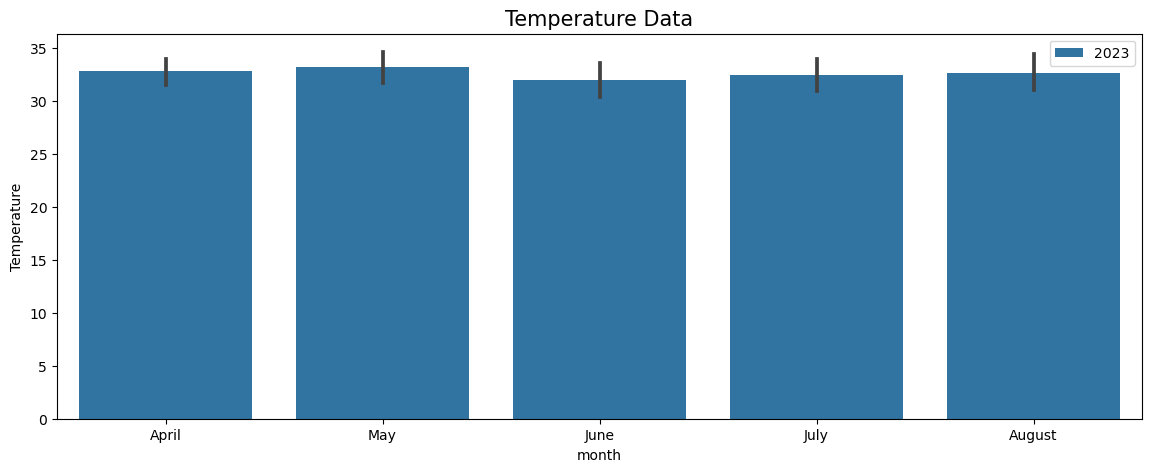

In [14]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Temperature",hue = 'year',data=df_temp)
a.set_title("Temperature Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

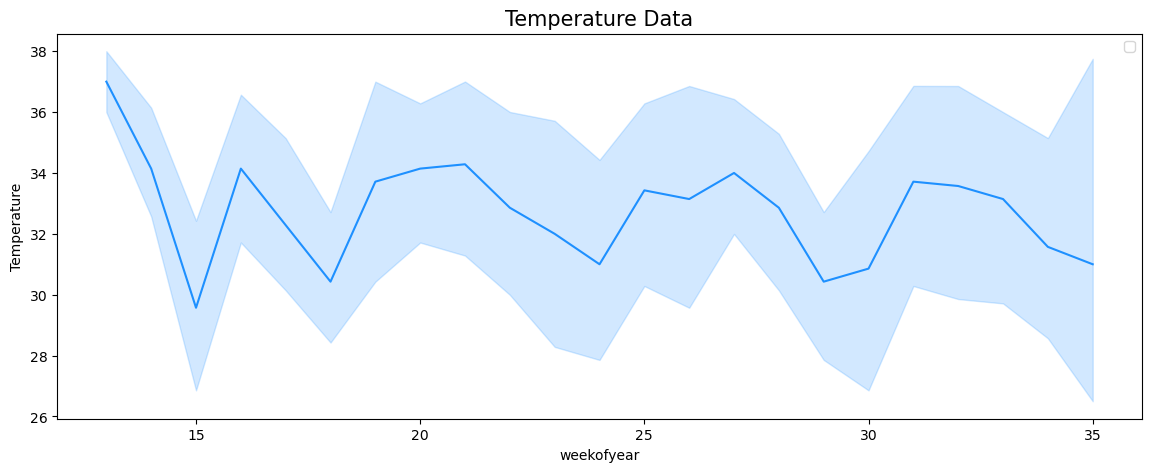

In [15]:

fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.lineplot(x=df_temp['weekofyear'], y=df_temp['Temperature'].fillna(method='ffill'), color='dodgerblue')
a.set_title("Temperature Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

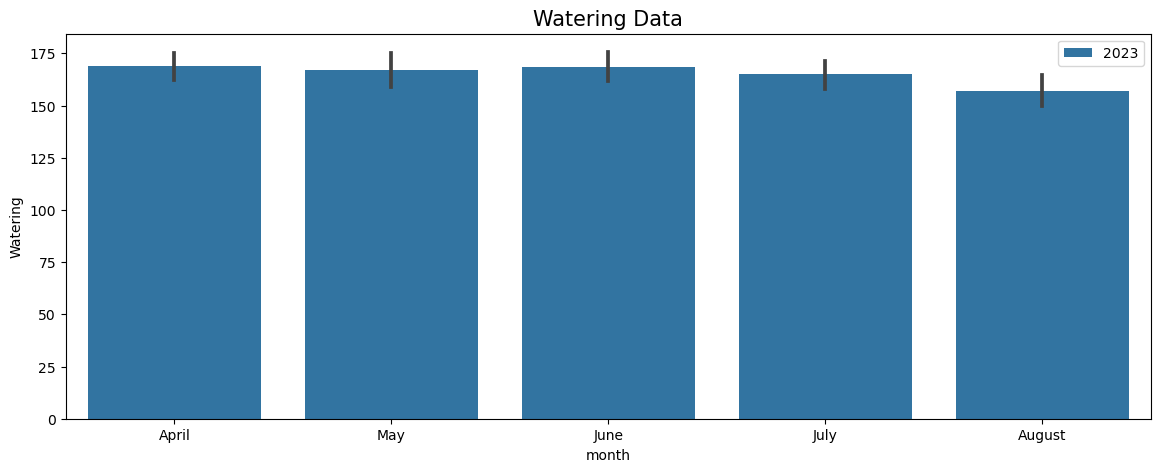

In [16]:
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="Watering",hue = 'year',data=df_water)
a.set_title("Watering Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

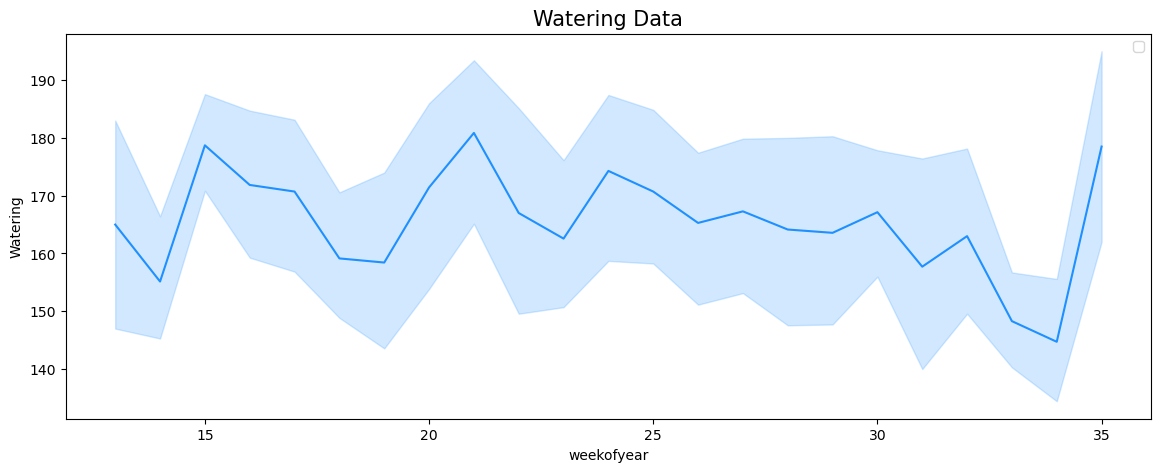

In [17]:

fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.lineplot(x=df_water['weekofyear'], y=df_water['Watering'].fillna(method='ffill'), color='dodgerblue')
a.set_title("Watering Data",fontsize=15)
plt.legend(loc='upper right')
plt.show()

<AxesSubplot:xlabel='Moisture', ylabel='Count'>

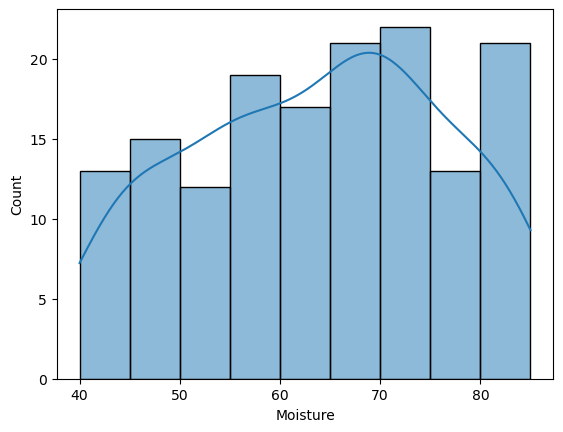

In [18]:
sns.histplot(x = df['Moisture'], kde = True)

<AxesSubplot:xlabel='Temperature', ylabel='Count'>

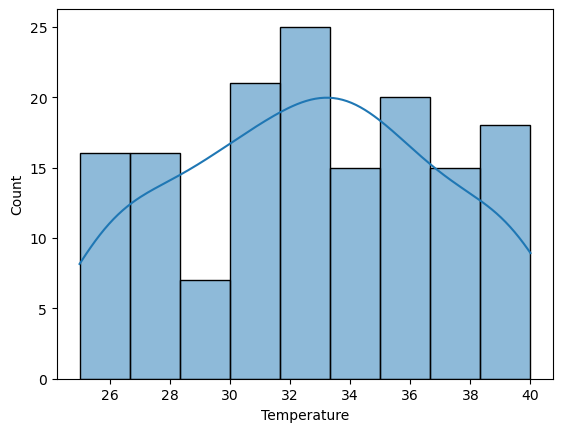

In [19]:
sns.histplot(x = df['Temperature'], kde = True)

<AxesSubplot:xlabel='Watering', ylabel='Count'>

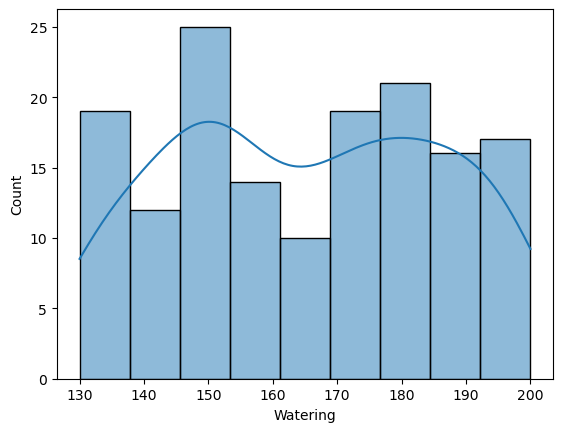

In [20]:
sns.histplot(x = df['Watering'], kde = True)

<AxesSubplot:>

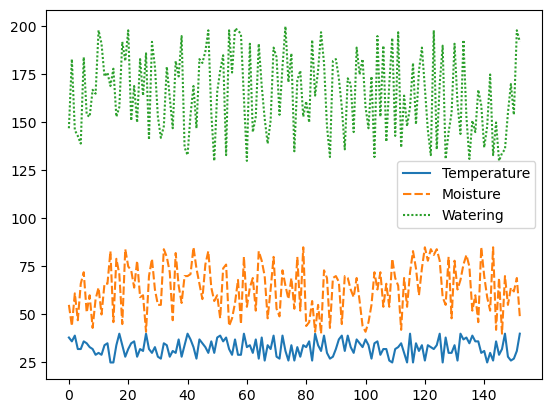

In [21]:
sns.lineplot(data=df)

## ***Data Preprocessing***

In [22]:
train_df.head()

,Date,Temperature,Moisture,Watering
0,2023-05-19,36,64,155
1,2023-04-26,31,60,164
2,2023-04-03,39,61,146
3,2023-04-22,35,73,151
4,2023-07-03,31,70,136


In [23]:
def data_process(data):
    df= data.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df.drop(columns=['Date'], inplace=True)

    return df

In [24]:
train= data_process(train_df)
train.head()

,Temperature,Moisture,Watering,Year,Month,Day,DayOfWeek,Quarter
0,36,64,155,2023,5,19,4,2
1,31,60,164,2023,4,26,2,2
2,39,61,146,2023,4,3,0,2
3,35,73,151,2023,4,22,5,2
4,31,70,136,2023,7,3,0,3


In [25]:
test=  data_process(test_df)
test.head()

,Temperature,Moisture,Watering,Year,Month,Day,DayOfWeek,Quarter
0,39,73,181,2023,6,26,0,2
1,38,60,166,2023,5,21,6,2
2,34,84,136,2023,8,3,3,3
3,35,84,148,2023,5,3,2,2
4,37,41,158,2023,7,10,0,3


In [26]:
X = train[['Temperature', 'Moisture','Year', 'Month', 'Day',
       'DayOfWeek', 'Quarter']]

y=  train['Watering']

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [28]:
test_x = test[['Temperature', 'Moisture','Year', 'Month', 'Day','DayOfWeek', 'Quarter']]
test_y = test['Watering']

# ***Linear Regression***


In [29]:
param_grid = {'fit_intercept': [True, False],
              
              'copy_X': [True, False]}

In [30]:
n_splits = 5

### ***1. Time series split & Grid Search***

In [31]:
tscv = TimeSeriesSplit(n_splits=n_splits)
model = LinearRegression()

In [32]:
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=tscv)

In [33]:
train.columns

Index(['Temperature', 'Moisture', 'Watering', 'Year', 'Month', 'Day',
       'DayOfWeek', 'Quarter'],
      dtype='object')

In [34]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [35]:
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'copy_X': True, 'fit_intercept': True}


In [36]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

In [37]:
mse = mean_squared_error(y_val, y_pred)
print("Mean squared error: ", mse)

Mean squared error:  485.71708625636614


### ***1.2 linear regression With KFOLD***

In [38]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores_lr = []
for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # train linear regression model
    
    best_model.fit(X_train_fold, y_train_fold)
    
    # evaluate the model on validation set
    y_val_pred = best_model.predict(X_val_fold)
    mse_scores_lr.append(mean_squared_error(y_val_fold, y_val_pred))

In [39]:
print(mse_scores_lr)

[227.5100916031917, 414.81394225355615, 376.2034273767566, 254.52067774057946, 413.4543014742996]


In [40]:
avg_mse_score_lr = sum(mse_scores_lr) / len(mse_scores_lr)

In [41]:
print(avg_mse_score_lr)

337.3004880896767


In [42]:
predicted_df_lr = test_df.copy()
pred_value= best_model.predict(test_x)
predicted_df_lr['pred_value']= pred_value
predicted_df_lr.head()

,Date,Temperature,Moisture,Watering,pred_value
0,2023-06-26,39,73,181,165.633664
1,2023-05-21,38,60,166,173.199600
2,2023-08-03,34,84,136,156.667653
3,2023-05-03,35,84,148,166.644032
4,2023-07-10,37,41,158,153.341618


In [43]:
mean_squared_error(pred_value, test_y)

643.8695737216019

# ***Decision Tree Regression***

In [44]:
from sklearn.tree import DecisionTreeRegressor


In [45]:
!pip install Optuna

In [46]:
import optuna

In [47]:
def objective(trial, data=X, target=y):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.18,random_state=3317)
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0)
    }

    model = DecisionTreeRegressor(**params)
    model.fit(train_x,train_y)
    
    preds = model.predict(test_x)
    mse = mean_squared_error(test_y, preds,squared=False)
    
    return mse

In [48]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-04-02 03:30:46,982] A new study created in memory with name: no-name-28836a1f-b618-4dae-ba7c-dd287bece37b
[I 2023-04-02 03:30:46,992] Trial 0 finished with value: 22.72884788786054 and parameters: {'max_depth': 30, 'min_samples_split': 26, 'min_samples_leaf': 16, 'max_features': 0.610833781240487}. Best is trial 0 with value: 22.72884788786054.
[I 2023-04-02 03:30:46,999] Trial 1 finished with value: 24.112771478715693 and parameters: {'max_depth': 28, 'min_samples_split': 24, 'min_samples_leaf': 10, 'max_features': 0.4789265388126296}. Best is trial 0 with value: 22.72884788786054.
[I 2023-04-02 03:30:47,006] Trial 2 finished with value: 21.717902094524295 and parameters: {'max_depth': 20, 'min_samples_split': 31, 'min_samples_leaf': 2, 'max_features': 0.5347419733777125}. Best is trial 2 with value: 21.717902094524295.
[I 2023-04-02 03:30:47,014] Trial 3 finished with value: 23.906373979103765 and parameters: {'max_depth': 27, 'min_samples_split': 31, 'min_samples_leaf': 4, '

Number of finished trials: 10
Best trial: {'max_depth': 21, 'min_samples_split': 16, 'min_samples_leaf': 29, 'max_features': 0.33392748925789445}


In [49]:
param = study.best_params

In [50]:

mse_scores_dt=[]
for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # train linear regression model
    
    dec_model = DecisionTreeRegressor(**param)

    dec_model.fit(X_train_fold, y_train_fold)
    
    # evaluate the model on validation set
    y_val_pred = dec_model.predict(X_val_fold)
    mse_scores_dt.append(mean_squared_error(y_val_fold, y_val_pred))

In [51]:
mse_scores_dt

[342.03034374999993,
 419.06664111108284,
 374.8351536072281,
 335.62267284482033,
 477.1706005103928]

In [52]:
avg_mse_score_dt=sum(mse_scores_dt)/len(mse_scores_dt)

In [53]:
print(avg_mse_score_dt)

389.74508236470473


In [54]:
predicted_df_dt = test_df.copy()
pred_value_dt= dec_model.predict(test_x)
predicted_df_dt['pred_value']= pred_value_dt
predicted_df_dt.head()

,Date,Temperature,Moisture,Watering,pred_value
0,2023-06-26,39,73,181,162.720930
1,2023-05-21,38,60,166,168.342857
2,2023-08-03,34,84,136,162.720930
3,2023-05-03,35,84,148,162.720930
4,2023-07-10,37,41,158,162.720930


In [55]:
mean_squared_error(pred_value_dt, test_y)

598.7584725797017

# ***CAT Boost Regressor***

In [73]:
!pip install catboost

In [74]:
from catboost import CatBoostRegressor

In [76]:
def objective_cat(trial, data=X, target=y):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.18,random_state=3317)
    
    param = {
      
      "eval_metric": trial.suggest_categorical("loss_function", ["RMSE","MAE"]),
      'random_state': 48,
      'iterations': 3500,
      'sampling_frequency': "PerTree",
      'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
      'colsample_bylevel': trial.suggest_float('colsample_bylevel',0.3, 1.0),
      'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
      'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
      'depth': trial.suggest_categorical('max_depth', [2, 4, 6, 8, 14]),

      'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
      }
    

 
    model = CatBoostRegressor(**param)  
    
    model.fit(train_x,train_y)
    
    preds = model.predict(test_x)
    
    mse = mean_squared_error(test_y, preds,squared=False)
    
    return mse

In [77]:
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=10)
print('Number of finished trials:', len(study_cat.trials))
print('Best trial:', study_cat.best_trial.params)

[I 2023-04-02 03:40:48,475] A new study created in memory with name: no-name-00ef7dc5-00f4-47a9-a6b7-36a64f96cb46
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


0:	learn: 16.5080095	total: 54.8ms	remaining: 3m 11s
1:	learn: 16.3290647	total: 56.2ms	remaining: 1m 38s
2:	learn: 16.2322776	total: 56.6ms	remaining: 1m 5s
3:	learn: 16.1063991	total: 57ms	remaining: 49.8s
4:	learn: 15.9131711	total: 58.5ms	remaining: 40.9s
5:	learn: 15.8585460	total: 58.7ms	remaining: 34.2s
6:	learn: 15.7870301	total: 58.9ms	remaining: 29.4s
7:	learn: 15.6858458	total: 59.1ms	remaining: 25.8s
8:	learn: 15.6743586	total: 59.2ms	remaining: 23s
9:	learn: 15.6498787	total: 59.3ms	remaining: 20.7s
10:	learn: 15.6343698	total: 59.4ms	remaining: 18.8s
11:	learn: 15.4393161	total: 60ms	remaining: 17.4s
12:	learn: 15.4100585	total: 60.1ms	remaining: 16.1s
13:	learn: 15.1769363	total: 71.3ms	remaining: 17.8s
14:	learn: 15.0521972	total: 72.4ms	remaining: 16.8s
15:	learn: 15.0203620	total: 72.9ms	remaining: 15.9s
16:	learn: 14.8614928	total: 84.3ms	remaining: 17.3s
17:	learn: 14.6292721	total: 85.7ms	remaining: 16.6s
18:	learn: 14.3934303	total: 90.8ms	remaining: 16.6s
19:	lea

[I 2023-04-02 03:41:04,092] Trial 0 finished with value: 23.974814205709393 and parameters: {'loss_function': 'MAE', 'reg_lambda': 0.0013689064009885293, 'colsample_bylevel': 0.49661015323968155, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 14, 'min_child_samples': 216}. Best is trial 0 with value: 23.974814205709393.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


0:	learn: 18.9472921	total: 463us	remaining: 1.62s
1:	learn: 18.8999773	total: 1.12ms	remaining: 1.96s
2:	learn: 18.8625629	total: 1.32ms	remaining: 1.54s
3:	learn: 18.8019950	total: 1.56ms	remaining: 1.36s
4:	learn: 18.7775392	total: 1.68ms	remaining: 1.17s
5:	learn: 18.7235009	total: 1.84ms	remaining: 1.07s
6:	learn: 18.6877843	total: 1.97ms	remaining: 984ms
7:	learn: 18.6487830	total: 2.11ms	remaining: 920ms
8:	learn: 18.5941943	total: 2.28ms	remaining: 884ms
9:	learn: 18.5344082	total: 2.43ms	remaining: 848ms
10:	learn: 18.4793552	total: 2.6ms	remaining: 825ms
11:	learn: 18.4137074	total: 2.73ms	remaining: 795ms
12:	learn: 18.3748621	total: 2.88ms	remaining: 773ms
13:	learn: 18.3515510	total: 3.02ms	remaining: 751ms
14:	learn: 18.3093330	total: 3.18ms	remaining: 740ms
15:	learn: 18.2719318	total: 3.33ms	remaining: 725ms
16:	learn: 18.2424266	total: 3.48ms	remaining: 713ms
17:	learn: 18.1752790	total: 3.64ms	remaining: 705ms
18:	learn: 18.1278311	total: 3.78ms	remaining: 693ms
19:	l

[I 2023-04-02 03:41:04,731] Trial 1 finished with value: 24.33720072398313 and parameters: {'loss_function': 'RMSE', 'reg_lambda': 0.0018473575230839073, 'colsample_bylevel': 0.7397745351638134, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 4, 'min_child_samples': 107}. Best is trial 0 with value: 23.974814205709393.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


0:	learn: 16.4957366	total: 280us	remaining: 981ms
1:	learn: 16.4508036	total: 847us	remaining: 1.48s
2:	learn: 16.3883387	total: 1.03ms	remaining: 1.2s
3:	learn: 16.3173198	total: 1.16ms	remaining: 1.01s
4:	learn: 16.2737900	total: 1.31ms	remaining: 917ms
5:	learn: 16.2486744	total: 1.46ms	remaining: 852ms
6:	learn: 16.2486763	total: 1.5ms	remaining: 751ms
7:	learn: 16.2257207	total: 1.65ms	remaining: 722ms
8:	learn: 16.2044750	total: 1.82ms	remaining: 705ms
9:	learn: 16.1518503	total: 1.95ms	remaining: 682ms
10:	learn: 16.1284023	total: 2.06ms	remaining: 654ms
11:	learn: 16.1012385	total: 2.21ms	remaining: 644ms
12:	learn: 16.0560736	total: 2.38ms	remaining: 637ms
13:	learn: 16.0310286	total: 2.53ms	remaining: 630ms
14:	learn: 15.9925641	total: 2.65ms	remaining: 616ms
15:	learn: 15.9352662	total: 2.77ms	remaining: 604ms
16:	learn: 15.8939534	total: 2.93ms	remaining: 600ms
17:	learn: 15.8939564	total: 2.98ms	remaining: 576ms
18:	learn: 15.8609604	total: 3.1ms	remaining: 568ms
19:	lear

[I 2023-04-02 03:41:05,325] Trial 2 finished with value: 25.2112138303077 and parameters: {'loss_function': 'MAE', 'reg_lambda': 0.04518083646285703, 'colsample_bylevel': 0.4472092889908806, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 4, 'min_child_samples': 298}. Best is trial 0 with value: 23.974814205709393.


2491:	learn: 0.7009771	total: 299ms	remaining: 121ms
2492:	learn: 0.7005462	total: 299ms	remaining: 121ms
2493:	learn: 0.7000952	total: 300ms	remaining: 121ms
2494:	learn: 0.6993052	total: 300ms	remaining: 121ms
2495:	learn: 0.6982624	total: 300ms	remaining: 121ms
2496:	learn: 0.6973846	total: 300ms	remaining: 121ms
2497:	learn: 0.6965726	total: 300ms	remaining: 120ms
2498:	learn: 0.6956452	total: 300ms	remaining: 120ms
2499:	learn: 0.6945234	total: 301ms	remaining: 120ms
2500:	learn: 0.6932924	total: 301ms	remaining: 120ms
2501:	learn: 0.6929415	total: 301ms	remaining: 120ms
2502:	learn: 0.6921815	total: 301ms	remaining: 120ms
2503:	learn: 0.6913954	total: 301ms	remaining: 120ms
2504:	learn: 0.6906150	total: 301ms	remaining: 120ms
2505:	learn: 0.6899669	total: 301ms	remaining: 120ms
2506:	learn: 0.6889332	total: 301ms	remaining: 119ms
2507:	learn: 0.6881923	total: 302ms	remaining: 119ms
2508:	learn: 0.6870809	total: 302ms	remaining: 119ms
2509:	learn: 0.6870809	total: 302ms	remaining:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


55:	learn: 16.0410642	total: 16.2ms	remaining: 995ms
56:	learn: 16.0347296	total: 16.4ms	remaining: 988ms
57:	learn: 16.0238446	total: 16.7ms	remaining: 994ms
58:	learn: 16.0161376	total: 17.1ms	remaining: 998ms
59:	learn: 16.0080538	total: 17.5ms	remaining: 1s
60:	learn: 15.9967701	total: 17.8ms	remaining: 1s
61:	learn: 15.9862608	total: 18.7ms	remaining: 1.04s
62:	learn: 15.9800855	total: 18.8ms	remaining: 1.03s
63:	learn: 15.9703257	total: 19.2ms	remaining: 1.03s
64:	learn: 15.9600442	total: 19.6ms	remaining: 1.04s
65:	learn: 15.9509474	total: 20.1ms	remaining: 1.05s
66:	learn: 15.9380164	total: 20.5ms	remaining: 1.05s
67:	learn: 15.9312314	total: 20.7ms	remaining: 1.04s
68:	learn: 15.9223939	total: 21ms	remaining: 1.04s
69:	learn: 15.9180539	total: 21.1ms	remaining: 1.03s
70:	learn: 15.9065303	total: 21.4ms	remaining: 1.03s
71:	learn: 15.8960036	total: 21.8ms	remaining: 1.04s
72:	learn: 15.8887764	total: 22.1ms	remaining: 1.04s
73:	learn: 15.8795591	total: 22.5ms	remaining: 1.04s
7

[I 2023-04-02 03:41:06,833] Trial 3 finished with value: 23.415328952842035 and parameters: {'loss_function': 'MAE', 'reg_lambda': 8.993773185688045, 'colsample_bylevel': 0.7471275756396509, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 8, 'min_child_samples': 183}. Best is trial 3 with value: 23.415328952842035.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


0:	learn: 18.9560418	total: 270us	remaining: 945ms
1:	learn: 18.9388244	total: 571us	remaining: 1000ms
2:	learn: 18.9249299	total: 638us	remaining: 744ms
3:	learn: 18.9163046	total: 696us	remaining: 609ms
4:	learn: 18.8344772	total: 1.11ms	remaining: 773ms
5:	learn: 18.8162033	total: 1.19ms	remaining: 692ms
6:	learn: 18.7945157	total: 1.27ms	remaining: 634ms
7:	learn: 18.7041589	total: 1.62ms	remaining: 709ms
8:	learn: 18.6985668	total: 1.7ms	remaining: 660ms
9:	learn: 18.6552767	total: 1.81ms	remaining: 631ms
10:	learn: 18.5869655	total: 2.15ms	remaining: 683ms
11:	learn: 18.5753076	total: 2.23ms	remaining: 647ms
12:	learn: 18.4789073	total: 5.27ms	remaining: 1.41s
13:	learn: 18.4663069	total: 5.34ms	remaining: 1.33s
14:	learn: 18.3661680	total: 6.8ms	remaining: 1.58s
15:	learn: 18.3393698	total: 6.9ms	remaining: 1.5s
16:	learn: 18.3393697	total: 6.93ms	remaining: 1.42s
17:	learn: 18.2655912	total: 7.22ms	remaining: 1.4s
18:	learn: 18.1686587	total: 8.35ms	remaining: 1.53s
19:	learn: 

[I 2023-04-02 03:41:11,599] Trial 4 finished with value: 23.832421969559565 and parameters: {'loss_function': 'RMSE', 'reg_lambda': 0.21493274385032038, 'colsample_bylevel': 0.3490777193868822, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 14, 'min_child_samples': 24}. Best is trial 3 with value: 23.415328952842035.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


0:	learn: 16.4762350	total: 395us	remaining: 1.39s
1:	learn: 16.3617615	total: 997us	remaining: 1.74s
2:	learn: 16.2952874	total: 1.2ms	remaining: 1.4s
3:	learn: 16.1921480	total: 1.36ms	remaining: 1.19s
4:	learn: 16.1151970	total: 1.55ms	remaining: 1.08s
5:	learn: 15.9911717	total: 1.74ms	remaining: 1.01s
6:	learn: 15.9293921	total: 1.93ms	remaining: 961ms
7:	learn: 15.8762292	total: 2.06ms	remaining: 899ms
8:	learn: 15.8124167	total: 2.23ms	remaining: 864ms
9:	learn: 15.7787080	total: 2.3ms	remaining: 804ms
10:	learn: 15.7436060	total: 2.47ms	remaining: 785ms
11:	learn: 15.7279484	total: 2.56ms	remaining: 745ms
12:	learn: 15.7181691	total: 2.6ms	remaining: 699ms
13:	learn: 15.6360109	total: 2.8ms	remaining: 697ms
14:	learn: 15.5938615	total: 3ms	remaining: 696ms
15:	learn: 15.5929578	total: 3.07ms	remaining: 669ms
16:	learn: 15.4827647	total: 3.25ms	remaining: 666ms
17:	learn: 15.4570826	total: 3.34ms	remaining: 647ms
18:	learn: 15.3911615	total: 3.5ms	remaining: 641ms
19:	learn: 15.

[I 2023-04-02 03:41:12,483] Trial 5 finished with value: 24.557639538109193 and parameters: {'loss_function': 'MAE', 'reg_lambda': 0.002394735994744606, 'colsample_bylevel': 0.5257589791568116, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 6, 'min_child_samples': 168}. Best is trial 3 with value: 23.415328952842035.


3444:	learn: 0.0004661	total: 645ms	remaining: 10.3ms
3445:	learn: 0.0004648	total: 646ms	remaining: 10.1ms
3446:	learn: 0.0004645	total: 646ms	remaining: 9.94ms
3447:	learn: 0.0004628	total: 647ms	remaining: 9.75ms
3448:	learn: 0.0004616	total: 647ms	remaining: 9.57ms
3449:	learn: 0.0004606	total: 647ms	remaining: 9.38ms
3450:	learn: 0.0004594	total: 647ms	remaining: 9.19ms
3451:	learn: 0.0004577	total: 648ms	remaining: 9ms
3452:	learn: 0.0004560	total: 648ms	remaining: 8.82ms
3453:	learn: 0.0004539	total: 648ms	remaining: 8.63ms
3454:	learn: 0.0004533	total: 648ms	remaining: 8.44ms
3455:	learn: 0.0004519	total: 649ms	remaining: 8.26ms
3456:	learn: 0.0004504	total: 649ms	remaining: 8.08ms
3457:	learn: 0.0004497	total: 650ms	remaining: 7.89ms
3458:	learn: 0.0004494	total: 650ms	remaining: 7.71ms
3459:	learn: 0.0004483	total: 650ms	remaining: 7.52ms
3460:	learn: 0.0004468	total: 651ms	remaining: 7.33ms
3461:	learn: 0.0004464	total: 651ms	remaining: 7.14ms
3462:	learn: 0.0004452	total: 6

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


793:	learn: 3.7927685	total: 91.4ms	remaining: 312ms
794:	learn: 3.7868619	total: 92ms	remaining: 313ms
795:	learn: 3.7801067	total: 92.2ms	remaining: 313ms
796:	learn: 3.7734773	total: 92.3ms	remaining: 313ms
797:	learn: 3.7675834	total: 92.5ms	remaining: 313ms
798:	learn: 3.7631359	total: 92.6ms	remaining: 313ms
799:	learn: 3.7587009	total: 92.8ms	remaining: 313ms
800:	learn: 3.7539867	total: 93ms	remaining: 313ms
801:	learn: 3.7447409	total: 93.1ms	remaining: 313ms
802:	learn: 3.7331231	total: 93.3ms	remaining: 313ms
803:	learn: 3.7281586	total: 93.4ms	remaining: 313ms
804:	learn: 3.7228435	total: 93.6ms	remaining: 313ms
805:	learn: 3.7166926	total: 93.7ms	remaining: 313ms
806:	learn: 3.7105012	total: 94ms	remaining: 314ms
807:	learn: 3.7043231	total: 94.2ms	remaining: 314ms
808:	learn: 3.6982471	total: 94.3ms	remaining: 314ms
809:	learn: 3.6902038	total: 94.5ms	remaining: 314ms
810:	learn: 3.6860332	total: 94.6ms	remaining: 314ms
811:	learn: 3.6761543	total: 94.8ms	remaining: 314ms

[I 2023-04-02 03:41:13,119] Trial 6 finished with value: 24.72708874860447 and parameters: {'loss_function': 'MAE', 'reg_lambda': 0.022169754937432208, 'colsample_bylevel': 0.610615802324158, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 4, 'min_child_samples': 6}. Best is trial 3 with value: 23.415328952842035.


3089:	learn: 0.1802844	total: 393ms	remaining: 52.2ms
3090:	learn: 0.1801315	total: 393ms	remaining: 52.1ms
3091:	learn: 0.1799055	total: 394ms	remaining: 51.9ms
3092:	learn: 0.1797283	total: 394ms	remaining: 51.8ms
3093:	learn: 0.1795356	total: 394ms	remaining: 51.7ms
3094:	learn: 0.1792932	total: 394ms	remaining: 51.5ms
3095:	learn: 0.1791603	total: 394ms	remaining: 51.4ms
3096:	learn: 0.1789795	total: 394ms	remaining: 51.3ms
3097:	learn: 0.1788123	total: 394ms	remaining: 51.1ms
3098:	learn: 0.1786511	total: 394ms	remaining: 51ms
3099:	learn: 0.1785456	total: 394ms	remaining: 50.9ms
3100:	learn: 0.1784336	total: 394ms	remaining: 50.8ms
3101:	learn: 0.1782204	total: 395ms	remaining: 50.6ms
3102:	learn: 0.1780378	total: 395ms	remaining: 50.5ms
3103:	learn: 0.1776738	total: 395ms	remaining: 50.4ms
3104:	learn: 0.1774095	total: 395ms	remaining: 50.2ms
3105:	learn: 0.1771811	total: 395ms	remaining: 50.1ms
3106:	learn: 0.1769499	total: 395ms	remaining: 50ms
3107:	learn: 0.1767733	total: 39

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


665:	learn: 10.6995112	total: 70.3ms	remaining: 299ms
666:	learn: 10.6911834	total: 70.4ms	remaining: 299ms
667:	learn: 10.6911835	total: 70.4ms	remaining: 299ms
668:	learn: 10.6781208	total: 70.5ms	remaining: 298ms
669:	learn: 10.6646644	total: 70.6ms	remaining: 298ms
670:	learn: 10.6587534	total: 70.7ms	remaining: 298ms
671:	learn: 10.6585081	total: 70.8ms	remaining: 298ms
672:	learn: 10.6502998	total: 70.9ms	remaining: 298ms
673:	learn: 10.6430444	total: 70.9ms	remaining: 297ms
674:	learn: 10.6327003	total: 71ms	remaining: 297ms
675:	learn: 10.6187668	total: 71.1ms	remaining: 297ms
676:	learn: 10.6082305	total: 71.2ms	remaining: 297ms
677:	learn: 10.6071977	total: 71.3ms	remaining: 297ms
678:	learn: 10.5997963	total: 71.4ms	remaining: 296ms
679:	learn: 10.5944286	total: 71.5ms	remaining: 296ms
680:	learn: 10.5944287	total: 71.5ms	remaining: 296ms
681:	learn: 10.5820260	total: 71.6ms	remaining: 296ms
682:	learn: 10.5683269	total: 71.7ms	remaining: 296ms
683:	learn: 10.5612406	total: 

[I 2023-04-02 03:41:13,695] Trial 7 finished with value: 24.820681646082015 and parameters: {'loss_function': 'MAE', 'reg_lambda': 0.008742600578795104, 'colsample_bylevel': 0.34330293693378855, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 4, 'min_child_samples': 217}. Best is trial 3 with value: 23.415328952842035.


3399:	learn: 3.1081011	total: 359ms	remaining: 10.5ms
3400:	learn: 3.1074970	total: 359ms	remaining: 10.4ms
3401:	learn: 3.1056929	total: 359ms	remaining: 10.3ms
3402:	learn: 3.1054430	total: 359ms	remaining: 10.2ms
3403:	learn: 3.1039805	total: 359ms	remaining: 10.1ms
3404:	learn: 3.1026475	total: 359ms	remaining: 10ms
3405:	learn: 3.1007191	total: 359ms	remaining: 9.91ms
3406:	learn: 3.0995749	total: 359ms	remaining: 9.81ms
3407:	learn: 3.0965782	total: 359ms	remaining: 9.7ms
3408:	learn: 3.0964021	total: 359ms	remaining: 9.6ms
3409:	learn: 3.0964020	total: 360ms	remaining: 9.49ms
3410:	learn: 3.0946389	total: 360ms	remaining: 9.38ms
3411:	learn: 3.0926221	total: 360ms	remaining: 9.28ms
3412:	learn: 3.0889097	total: 360ms	remaining: 9.17ms
3413:	learn: 3.0880234	total: 360ms	remaining: 9.06ms
3414:	learn: 3.0852213	total: 360ms	remaining: 8.96ms
3415:	learn: 3.0849764	total: 360ms	remaining: 8.85ms
3416:	learn: 3.0830331	total: 360ms	remaining: 8.74ms
3417:	learn: 3.0815564	total: 36

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


455:	learn: 12.8328783	total: 120ms	remaining: 798ms
456:	learn: 12.8138480	total: 120ms	remaining: 799ms
457:	learn: 12.8022732	total: 120ms	remaining: 800ms
458:	learn: 12.7899253	total: 121ms	remaining: 801ms
459:	learn: 12.7805337	total: 121ms	remaining: 801ms
460:	learn: 12.7684327	total: 122ms	remaining: 801ms
461:	learn: 12.7592609	total: 122ms	remaining: 803ms
462:	learn: 12.7459451	total: 122ms	remaining: 802ms
463:	learn: 12.7331213	total: 123ms	remaining: 807ms
464:	learn: 12.7189821	total: 124ms	remaining: 807ms
465:	learn: 12.7050659	total: 124ms	remaining: 807ms
466:	learn: 12.6902103	total: 124ms	remaining: 808ms
467:	learn: 12.6761579	total: 125ms	remaining: 808ms
468:	learn: 12.6635992	total: 125ms	remaining: 808ms
469:	learn: 12.6534036	total: 125ms	remaining: 808ms
470:	learn: 12.6376543	total: 126ms	remaining: 808ms
471:	learn: 12.6199691	total: 126ms	remaining: 808ms
472:	learn: 12.6166838	total: 126ms	remaining: 807ms
473:	learn: 12.6018875	total: 126ms	remaining:

[I 2023-04-02 03:41:15,014] Trial 8 finished with value: 23.90628883224884 and parameters: {'loss_function': 'RMSE', 'reg_lambda': 7.237353535996185, 'colsample_bylevel': 0.5382046670490845, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_samples': 114}. Best is trial 3 with value: 23.415328952842035.


3306:	learn: 1.2861432	total: 996ms	remaining: 58.1ms
3307:	learn: 1.2854293	total: 997ms	remaining: 57.8ms
3308:	learn: 1.2846862	total: 997ms	remaining: 57.5ms
3309:	learn: 1.2832861	total: 997ms	remaining: 57.2ms
3310:	learn: 1.2827037	total: 997ms	remaining: 56.9ms
3311:	learn: 1.2814205	total: 998ms	remaining: 56.6ms
3312:	learn: 1.2805914	total: 998ms	remaining: 56.3ms
3313:	learn: 1.2801780	total: 998ms	remaining: 56ms
3314:	learn: 1.2786594	total: 999ms	remaining: 55.7ms
3315:	learn: 1.2777604	total: 1000ms	remaining: 55.5ms
3316:	learn: 1.2772066	total: 1s	remaining: 55.2ms
3317:	learn: 1.2762031	total: 1s	remaining: 54.9ms
3318:	learn: 1.2745042	total: 1s	remaining: 54.6ms
3319:	learn: 1.2732481	total: 1s	remaining: 54.3ms
3320:	learn: 1.2728619	total: 1s	remaining: 54ms
3321:	learn: 1.2712497	total: 1s	remaining: 53.7ms
3322:	learn: 1.2703306	total: 1s	remaining: 53.4ms
3323:	learn: 1.2694965	total: 1s	remaining: 53.1ms
3324:	learn: 1.2691388	total: 1s	remaining: 52.8ms
3325

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


118:	learn: 14.7931158	total: 42.1ms	remaining: 1.19s
119:	learn: 14.7585345	total: 42.9ms	remaining: 1.21s
120:	learn: 14.7219571	total: 43.3ms	remaining: 1.21s
121:	learn: 14.6918124	total: 43.8ms	remaining: 1.21s
122:	learn: 14.6855185	total: 44.1ms	remaining: 1.21s
123:	learn: 14.6735933	total: 44.3ms	remaining: 1.21s
124:	learn: 14.6443872	total: 44.6ms	remaining: 1.2s
125:	learn: 14.6068800	total: 45ms	remaining: 1.21s
126:	learn: 14.5854018	total: 45.3ms	remaining: 1.2s
127:	learn: 14.5821499	total: 45.4ms	remaining: 1.2s
128:	learn: 14.5482272	total: 45.8ms	remaining: 1.2s
129:	learn: 14.5082488	total: 46.1ms	remaining: 1.2s
130:	learn: 14.4774627	total: 46.4ms	remaining: 1.19s
131:	learn: 14.4507956	total: 46.8ms	remaining: 1.19s
132:	learn: 14.4143717	total: 47.1ms	remaining: 1.19s
133:	learn: 14.3940431	total: 47.4ms	remaining: 1.19s
134:	learn: 14.3753861	total: 47.6ms	remaining: 1.19s
135:	learn: 14.3707487	total: 47.8ms	remaining: 1.18s
136:	learn: 14.3473584	total: 48ms	

[I 2023-04-02 03:41:16,590] Trial 9 finished with value: 23.79612574423324 and parameters: {'loss_function': 'RMSE', 'reg_lambda': 0.3263302350392428, 'colsample_bylevel': 0.9933763356449763, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 8, 'min_child_samples': 173}. Best is trial 3 with value: 23.415328952842035.


3492:	learn: 0.0459241	total: 1.3s	remaining: 2.6ms
3493:	learn: 0.0458606	total: 1.3s	remaining: 2.23ms
3494:	learn: 0.0457732	total: 1.3s	remaining: 1.86ms
3495:	learn: 0.0456951	total: 1.3s	remaining: 1.49ms
3496:	learn: 0.0456087	total: 1.3s	remaining: 1.12ms
3497:	learn: 0.0455283	total: 1.3s	remaining: 744us
3498:	learn: 0.0454478	total: 1.3s	remaining: 372us
3499:	learn: 0.0454235	total: 1.3s	remaining: 0us
Number of finished trials: 10
Best trial: {'loss_function': 'MAE', 'reg_lambda': 8.993773185688045, 'colsample_bylevel': 0.7471275756396509, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 8, 'min_child_samples': 183}


In [78]:
param_cat = study_cat.best_params

In [79]:

mse_scores_cat=[]
for train_idx, val_idx in kf.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # train linear regression model
    
    xgb_model = CatBoostRegressor(**param_cat)

    xgb_model.fit(X_train_fold, y_train_fold)
    
    # evaluate the model on validation set
    y_val_pred = xgb_model.predict(X_val_fold)
    mse_scores_cat.append(mean_squared_error(y_val_fold, y_val_pred))

0:	learn: 16.5268302	total: 1.91ms	remaining: 1.91s
1:	learn: 16.4502381	total: 3.28ms	remaining: 1.64s
2:	learn: 16.3832892	total: 4.22ms	remaining: 1.4s
3:	learn: 16.3185745	total: 4.69ms	remaining: 1.17s
4:	learn: 16.2927657	total: 4.9ms	remaining: 975ms
5:	learn: 16.2669148	total: 5.06ms	remaining: 838ms
6:	learn: 16.1950799	total: 5.4ms	remaining: 767ms
7:	learn: 16.1264758	total: 5.72ms	remaining: 709ms
8:	learn: 16.0641944	total: 6.05ms	remaining: 667ms
9:	learn: 16.0374879	total: 6.26ms	remaining: 620ms
10:	learn: 16.0151964	total: 6.41ms	remaining: 576ms
11:	learn: 15.9900788	total: 6.53ms	remaining: 538ms
12:	learn: 15.9587626	total: 6.76ms	remaining: 513ms
13:	learn: 15.9157420	total: 7.07ms	remaining: 498ms
14:	learn: 15.8736182	total: 7.3ms	remaining: 479ms
15:	learn: 15.8100608	total: 7.63ms	remaining: 470ms
16:	learn: 15.7441030	total: 7.99ms	remaining: 462ms
17:	learn: 15.6902582	total: 8.38ms	remaining: 457ms
18:	learn: 15.6401903	total: 8.72ms	remaining: 450ms
19:	lea

In [80]:
avg_mse_score_cat=sum(mse_scores_cat)/len(mse_scores_cat)

print(avg_mse_score_cat)

396.2411412013218


In [81]:
predicted_df_cat = test_df.copy()
pred_value_cat= xgb_model.predict(test_x)
predicted_df_cat['pred_value']= pred_value_cat
predicted_df_cat.head()

,Date,Temperature,Moisture,Watering,pred_value
0,2023-06-26,39,73,181,169.162759
1,2023-05-21,38,60,166,163.647588
2,2023-08-03,34,84,136,155.471979
3,2023-05-03,35,84,148,168.053890
4,2023-07-10,37,41,158,155.800640


In [82]:
mean_squared_error(pred_value_cat, test_y)

670.3747498128549